# Final Project: Click-through Rate Prediction
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

We've been provided a week’s worth of Criteo display advertising data to develop models predicting ad click-through rate (CTR). Our aim is to generate precise and accurate probabilities that a consumer will click on a given ad based on the user and the page visited.


## About the Data:

The dataset contains 2 files: train.txt and test.txt. The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo and the first column indicates whether this ad has been clicked or not. The positive (clicked) and negatives (non-clicked) examples have both been subsampled (but at different rates) in order to reduce the dataset size. The rows are chronologically ordered.

There are 13 features taking integer values (mostly count features) and 26 categorical features. The values of the categorical features have been hashed onto 32 bits for anonymization purposes. The semantic of these features is undisclosed. Some features may have missing values. 

The test set is computed in the same way as the training set but it corresponds to events on the day following the training period. The first column (label) has been removed.


## Rubric under Consideration:

1. Question Formulation -- Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful.

2. Algorithm Explanation -- Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform.

3. EDA & Discussion of Challenges -- Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform.

4. Algorithm Implementation -- develop a ‘homegrown’ implementation of the algorithm, apply it to the training dataset and evaluate your results on the test set.

5. Application of Course Concepts -- Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts.

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [1]:
# imports
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [34]:
#pyspark dependencies
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.sql import SQLContext, functions as f
from pyspark.sql.types import *

In [ ]:
# make a data folder, download, and unpack file
!mkdir data
!wget "https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz"
!tar xvzf dac.tar.gz
!mv *.txt data

### Looking into Test Data

In [21]:
#----per readme: when a value is missing, the field is just empty---#
file = "data/test.txt"
df = spark.read.schema(schema) \
    .option("delimiter", "\t") \
    .option("ignoreLeadingWhiteSpace",True) \
    .option("ignoreTrailingWhiteSpace",True) \
    .csv(file,nullValue = "")

In [11]:
intCols = [i for i in df.columns if "int" in i]
df.select(intCols).describe().write \
    .option("header", "true") \
    .csv("eda/tester")

In [17]:
#df.columns

 ['intFeature1',
 'intFeature2',
 'intFeature3',
 'intFeature4',
 'intFeature5',
 'intFeature6',
 'intFeature7',
 'intFeature8',
 'intFeature9',
 'intFeature10',
 'intFeature11',
 'intFeature12',
 'intFeature13']

In [12]:
#consolidating summary files
import glob
files = np.sort(glob.glob('eda/test/*.csv'))
summary = pd.concat([pd.read_csv(f) for f in files],ignore_index = True)

In [13]:
summary

,summary,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,intFeature10,intFeature11,intFeature12,intFeature13
0,count,120196.000000,94203.000000,93704.000000,1.171580e+05,95371.000000,115213.000000,120132.000000,115213.000000,69409.000000,115213.000000,30032.000000,93704.000000,1.201960e+05
1,mean,107.687885,28.288080,7.315899,1.634212e+04,112.527372,18.931145,12.439258,114.531164,0.596032,3.072579,1.042088,8.105470,8.434298e+07
2,stddev,390.569135,437.011635,8.655582,6.281999e+04,303.423928,66.871803,13.696133,229.713966,0.689551,5.719523,8.332484,11.887921,1.464619e+07
3,min,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.930803e+06
4,max,11347.000000,36935.000000,144.000000,2.079817e+06,15211.000000,3573.000000,650.000000,8880.000000,7.000000,141.000000,1169.000000,603.000000,9.823773e+07


In [19]:
#consolidating summary files
import glob
files = np.sort(glob.glob('data/Deduped_initSummary.csv/*.csv'))
train_summary = pd.concat([pd.read_csv(f) for f in files],ignore_index = True)
train_summary[ ['summary','intFeature1',
 'intFeature2',
 'intFeature3',
 'intFeature4',
 'intFeature5',
 'intFeature6',
 'intFeature7',
 'intFeature8',
 'intFeature9',
 'intFeature10',
 'intFeature11',
 'intFeature12',
 'intFeature13']]

,summary,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,intFeature10,intFeature11,intFeature12,intFeature13
0,count,2.504679e+07,4.582997e+07,3.599789e+07,3.590206e+07,4.465700e+07,3.558790e+07,4.385496e+07,4.580805e+07,4.385496e+07,2.504679e+07,4.385496e+07,1.076885e+07,3.590206e+07
1,mean,3.502407e+00,1.058717e+02,2.691484e+01,7.322788e+00,1.853901e+04,1.160619e+02,1.633396e+01,1.251952e+01,1.061153e+02,6.175283e-01,2.732977e+00,9.910259e-01,8.217598e+00
2,stddev,9.429087e+00,3.914979e+02,3.979877e+02,8.793271e+00,6.939451e+04,3.825674e+02,6.605146e+01,1.668970e+01,2.202880e+02,6.840501e-01,5.199166e+00,5.597665e+00,1.621213e+01
3,min,0.000000e+00,-3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,max,5.775000e+03,2.576750e+05,6.553500e+04,9.690000e+02,2.315946e+07,4.310370e+05,5.631100e+04,6.047000e+03,2.901900e+04,1.100000e+01,2.310000e+02,4.008000e+03,7.393000e+03


### Reading and Processing Data

In [20]:
#set dataframe schema
#--- To avoid going through the entire data once, disable inferSchema option or specify the schema explicitly using schema

# 13 features taking integer values and 26 taking categorical values (we can't assume ordinal) - making total of 39 features + 1 outcome
#outcomeField = [StructField("label", IntegerType(), True)]
#outcomeField +
quantFields = [StructField("intFeature"+str(i+1), IntegerType(), True) for i in np.arange(13)]
qualFields = [StructField("catFeature"+str(i+1), StringType(), True) for i in np.arange(26)]
schema = StructType(quantFields + qualFields)

In [167]:
#read in the txt file
#----per readme: when a value is missing, the field is just empty---#
file = "data/train.txt"
df = spark.read.schema(schema) \
    .option("delimiter", "\t") \
    .option("ignoreLeadingWhiteSpace",True) \
    .option("ignoreTrailingWhiteSpace",True) \
    .csv(file,nullValue = "")

In [8]:
df.show(5)

+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|label|intFeature1|intFeature2|intFeature3|intFeature4|intFeature5|intFeature6|intFeature7|intFeature8|intFeature9|intFeature10|intFeature11|intFeature12|intFeature13|catFeature1|catFeature2|catFeature3|catFeature4|catFeature5|catFeature6|catFeature7|catFeature8|catFeature9|catFeature10|catFeature11|catFeature12|catFeature13|catFeature14|catFeature15|catFeature16|catFeature17|catFeature18|catFeature19|catFeature20|catFeature21|catFeature22|catFeature23|catFeature24|catFeature25|catFeature26|
+-----

In [19]:
#total number of rows in the dataset
df.count()

45840617

In [171]:
#checking for duplicate entries
dedupedDF = df.dropDuplicates()

In [25]:
dedupedDF.count()

45829966

In [28]:
print(str(45840617-45829966)+" duplicates removed from dataset")

10651 duplicates removed from dataset


In [172]:
#remove all rows that have missing values for each feature
deduped_NAdropped_DF = dedupedDF.dropna(how='all')

In [11]:
deduped_NAdropped_DF.count()

45829966

In [175]:
#check num of rows missing 3/4 or more of total features values
deduped_NAdropped_thresh = deduped_NAdropped_DF.dropna(thresh=30)

In [176]:
deduped_NAdropped_thresh.count()

41879511

In [12]:
print(str(45829966-45829966)+" rows had all of their data marked as null")

0 rows had all of their data marked as null


In [177]:
print(str(45829966-41879511)+" rows had 3/4 of their data marked as null")

3950455 rows had 3/4 of their data marked as null


In [30]:
#quick summary of the data
dfSummary = dedupedDF.describe()

dfSummary.write \
    .option("header", "true") \
    .csv("data/Deduped_initSummary.csv")

In [110]:
#consolidating summary files
import glob
files = np.sort(glob.glob('data/Deduped_initSummary.csv/*.csv'))
summary = pd.concat([pd.read_csv(f) for f in files],ignore_index = True)

In [111]:
#let's get a sense of data completeness
'''the 1st row from the summary table is count (excludes nulls), 
so we can divide that by the total rows for feature completeness'''
perc_complete = summary.iloc[0][1:].apply(lambda x: x/nrows)
#features with more than 10% of their values missing
perc_complete[perc_complete<.9].sort_values()

intFeature12    0.234974
catFeature22    0.237488
intFeature1     0.546516
intFeature10    0.546516
catFeature19    0.560051
catFeature20    0.560051
catFeature25    0.560051
catFeature26    0.560051
intFeature6     0.776520
intFeature4     0.783375
intFeature13    0.783375
intFeature3     0.785466
catFeature6     0.879118
Name: 0, dtype: float64

In [109]:
#summary of our integer variables
'''integer features are 1st 15 coumns in dataset'''
summary[summary.columns[0:15]].round(decimals = 2)

,summary,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,intFeature10,intFeature11,intFeature12,intFeature13
0,count,45829966.00,25046791.00,45829966.00,35997892.00,35902063.00,44657003.00,35587905.00,43854960.00,45808048.00,43854960.00,25046791.00,43854960.00,10768852.00,35902063.00
1,mean,0.26,3.50,105.87,26.91,7.32,18539.01,116.06,16.33,12.52,106.12,0.62,2.73,0.99,8.22
2,stddev,0.44,9.43,391.50,397.99,8.79,69394.51,382.57,66.05,16.69,220.29,0.68,5.20,5.60,16.21
3,min,0.00,0.00,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,max,1.00,5775.00,257675.00,65535.00,969.00,23159456.00,431037.00,56311.00,6047.00,29019.00,11.00,231.00,4008.00,7393.00


~ 1/5 of our features are missing close to half or more values

Initial Observations of Quantitative Features:

* The ranges vary substantially across the integer features so we'll need to normalize these features to scale
* Major variances between the max values and the mean values are suggestive of outliers and/or features with skewed distributions
* intFeature2 has at least one negative value which seems erroneous

### EDA of our Quant Features

* will need to take a sample - discuss sample size decision (at least 50 observations per subset in categorical features???

In [37]:
#create separate directory for EDA files
!mkdir eda

In [20]:
#approximate count of unique values per feature
from pyspark.sql.functions import col, approx_count_distinct

uniqueVals = deduped_NAdropped_DF \
                .agg(*(approx_count_distinct(col(c)).alias(c) for c in deduped_NAdropped_DF.columns)) \
                .collect()


[See reference for counting unique values in each column of a Pyspark Dataframe](https://stackoverflow.com/questions/40888946/spark-dataframe-count-distinct-values-of-every-column)

In [62]:
#converting to pandas dataframe for familiarity
uniqueCounts = pd.DataFrame(uniqueVals,columns = deduped_NAdropped_DF.columns) \
                .transpose() \
                .reset_index() \
                .sort_values(by = 0, ascending = False)


#write to eda directory for later use
fpath = "eda/featureCounts_unique.csv"
uniqueCounts.to_csv(fpath, header = ["Feature Name","Approximate Unique Values"], index = False)

In [64]:
#take a subset of the (deduped) training data for EDA - 5% in this case - and write to file for later use
trainSample = deduped_NAdropped_DF.sample(False, 0.05, 123)

trainSample.write \
    .option("header", "true") \
    .csv("eda/trainSample")

In [48]:
#load the trainSample into memory with a pandas dataframe
import glob
files = np.sort(glob.glob('eda/trainSample/*.csv'))
trainSample = pd.concat([pd.read_csv(f) for f in files],ignore_index = True)

In [132]:
trainSample.head()

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,catFeature17,catFeature18,catFeature19,catFeature20,catFeature21,catFeature22,catFeature23,catFeature24,catFeature25,catFeature26
0,0,NaN,-2,31.0,4.0,33060.0,NaN,0.0,3.0,4.0,...,1e88c74f,9880032b,21ddcdc9,5840adea,baf3777b,NaN,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,NaN,-2,1.0,NaN,6576.0,3.0,6.0,0.0,76.0,...,e5ba7672,47e4d79e,21ddcdc9,a458ea53,f93c1581,NaN,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,0.0,-2,4.0,2.0,2921.0,52.0,25.0,16.0,146.0,...,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,NaN,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,0.0,-2,13.0,12.0,3271.0,59.0,7.0,20.0,89.0,...,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,ad3062eb,32c7478e,1793a828,e8b83407,2fede552
4,0,0.0,-2,3.0,44.0,1897.0,199.0,3.0,43.0,147.0,...,07c540c4,e7e991cb,68c36492,a458ea53,c39d0f12,NaN,3a171ecb,abec2c22,fd2fe0bd,22538d57


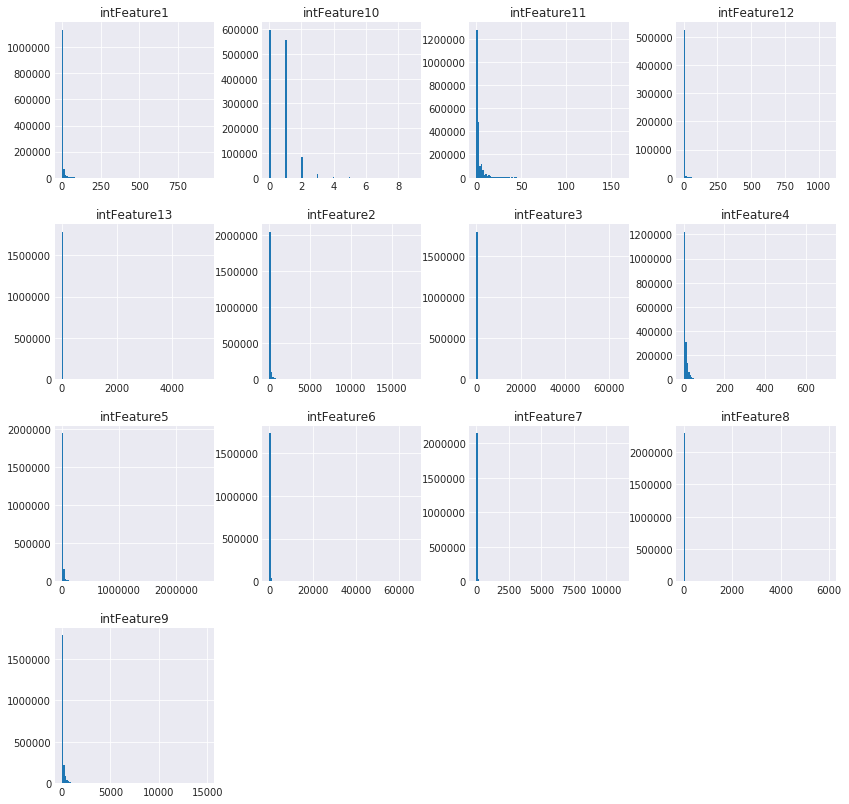

In [49]:
# take a look at histograms for each integer feature
intFeatures = trainSample.columns[1:14]
trainSample[intFeatures].hist(figsize=(14,14), bins=100)
plt.show()

we can see that our variables are heavily positive (right) skewed toward smaller integer values. We may be able to approximate normal distributions via log transformations. If we can demonstate approximate normal distributions among our variables, we can apply inferences from the logistic regression model. The logistic regression model assumes that the log-odds of an observation y can be expressed as a linear function of the input variables x.

In [50]:
#checking how many negative values intFeature2 has
f2 = trainSample['intFeature2']
len(f2[f2<0])

236565

the number of negative entries, 236,565, in intFeature2 make up ~0.5% of all entries so it may be reasonable to assume that these should have been coded as missing values or may have been incorrectly assigned a negative value.

In [51]:
#replace negative values with NaNs in intFeature2
neg_vals = f2[f2<0].unique()
trainSample.intFeature2 = trainSample['intFeature2'].replace(to_replace = neg_vals, value = np.NaN)

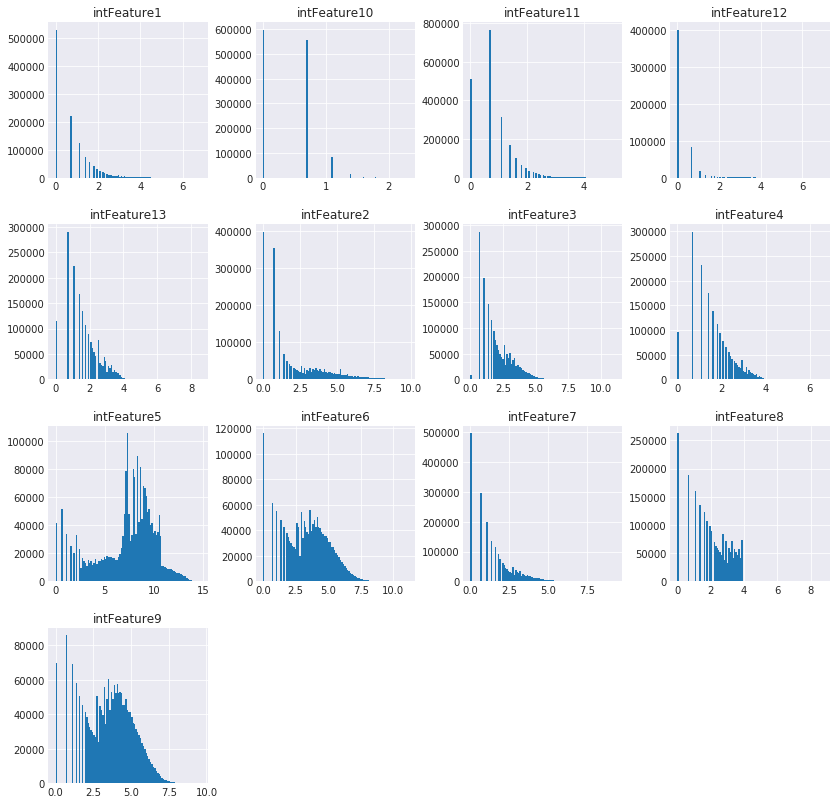

In [52]:
#helper function to log transform int features (should log transform first)
def log_transform(x):
    #takes a series
    '''shifts x up by one to account for presence of 0 values'
    and assumes negative values should be NaN'''
    return np.log(x+1)

#plotting log transformed integerFeatures
trainSample[intFeatures].apply(log_transform).hist(figsize=(14,14), bins=100)
plt.show()

Even after log transformation the integer data is still very skewed, but it looks more manageable

In [55]:
#apply log transformation to integer variables
trainSample[intFeatures] = trainSample[intFeatures].apply(log_transform)

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,catFeature17,catFeature18,catFeature19,catFeature20,catFeature21,catFeature22,catFeature23,catFeature24,catFeature25,catFeature26
0,0,NaN,NaN,3.465736,1.609438,10.406110,NaN,0.000000,1.386294,1.609438,...,1e88c74f,9880032b,21ddcdc9,5840adea,baf3777b,NaN,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,NaN,NaN,0.693147,NaN,8.791334,1.386294,1.945910,0.000000,4.343805,...,e5ba7672,47e4d79e,21ddcdc9,a458ea53,f93c1581,NaN,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,0.0,NaN,1.609438,1.098612,7.980024,3.970292,3.258097,2.833213,4.990433,...,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,NaN,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,0.0,NaN,2.639057,2.564949,8.093157,4.094345,2.079442,3.044522,4.499810,...,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,ad3062eb,32c7478e,1793a828,e8b83407,2fede552
4,0,0.0,NaN,1.386294,3.806662,7.548556,5.298317,1.386294,3.784190,4.997212,...,07c540c4,e7e991cb,68c36492,a458ea53,c39d0f12,NaN,3a171ecb,abec2c22,fd2fe0bd,22538d57


In [63]:
#normalize log-transformed features to rescale
def normalize(series):
    mn = series.mean()
    std = series.std()
    
    return (series-mn)/std

#don't normalize label
trainSample[intFeatures] = trainSample[intFeatures].apply(normalize)
trainSample.head(5)

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,catFeature17,catFeature18,catFeature19,catFeature20,catFeature21,catFeature22,catFeature23,catFeature24,catFeature25,catFeature26
0,0,NaN,NaN,1.099131,-0.101163,1.067417,NaN,-1.188550,-0.565069,-1.189582,...,1e88c74f,9880032b,21ddcdc9,5840adea,baf3777b,NaN,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,NaN,NaN,-1.221917,NaN,0.515437,-1.153559,0.226893,-1.764770,0.495264,...,e5ba7672,47e4d79e,21ddcdc9,a458ea53,f93c1581,NaN,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,-0.894306,NaN,-0.454853,-0.665177,0.238106,0.325690,1.181370,0.687097,0.893698,...,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,NaN,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,-0.894306,NaN,0.407084,0.953840,0.276778,0.396706,0.324023,0.869964,0.591389,...,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,ad3062eb,32c7478e,1793a828,e8b83407,2fede552
4,0,-0.894306,NaN,-0.641655,2.324844,0.090617,1.085939,-0.180168,1.510073,0.897876,...,07c540c4,e7e991cb,68c36492,a458ea53,c39d0f12,NaN,3a171ecb,abec2c22,fd2fe0bd,22538d57


In [64]:
#write to file for later use
fpath = 'eda/trainSampleNorm.csv'
trainSample.to_csv(path_or_buf = fpath, index = False)

In [6]:
#read in normalized train data
trainSampleLogNorm = pd.read_csv('eda/trainSampleNorm.csv')
trainSampleLogNorm.head(5)

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,catFeature17,catFeature18,catFeature19,catFeature20,catFeature21,catFeature22,catFeature23,catFeature24,catFeature25,catFeature26
0,0,NaN,NaN,1.099131,-0.101163,1.067417,NaN,-1.188550,-0.565069,-1.189582,...,1e88c74f,9880032b,21ddcdc9,5840adea,baf3777b,NaN,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,NaN,NaN,-1.221917,NaN,0.515437,-1.153559,0.226893,-1.764770,0.495264,...,e5ba7672,47e4d79e,21ddcdc9,a458ea53,f93c1581,NaN,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,-0.894306,NaN,-0.454853,-0.665177,0.238106,0.325690,1.181370,0.687097,0.893698,...,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,NaN,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,-0.894306,NaN,0.407084,0.953840,0.276778,0.396706,0.324023,0.869964,0.591389,...,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,ad3062eb,32c7478e,1793a828,e8b83407,2fede552
4,0,-0.894306,NaN,-0.641655,2.324844,0.090617,1.085939,-0.180168,1.510073,0.897876,...,07c540c4,e7e991cb,68c36492,a458ea53,c39d0f12,NaN,3a171ecb,abec2c22,fd2fe0bd,22538d57


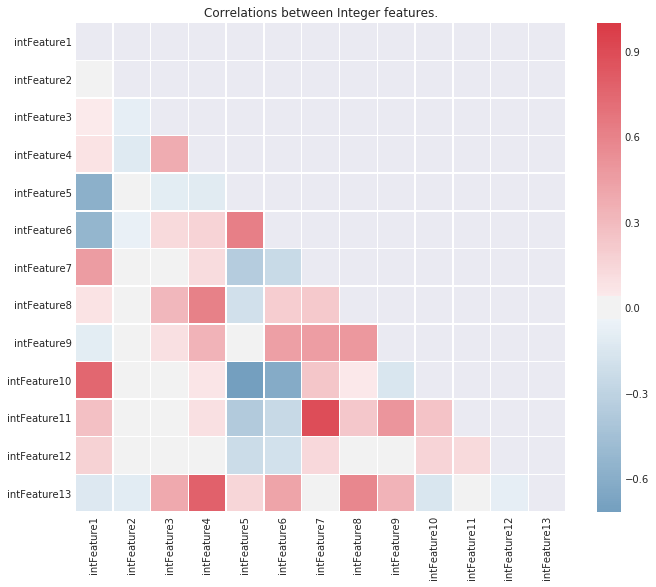

In [68]:
# plot heatmap for correlations matrix among integer features
intFeatures = trainSampleNorm.columns[1:14]

corr = trainSampleLogNorm[intFeatures].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between Integer features.")
plt.show()

assumption in logistic regression is no perfect collinearity so not to worried about the few high correlations between:
* intFeature 4 and intFeature13
* intFeature 8 and intFeature13
* intFeature 7 and intFeature11

/opt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


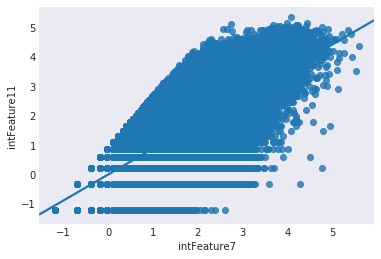

In [27]:
import seaborn as sns
# fig, ax_grid = plt.subplots(2, 1, figsize=(15,15)
sns.regplot(x='intFeature7', y="intFeature11",data=trainSampleLogNorm)                            
plt.show()

/opt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


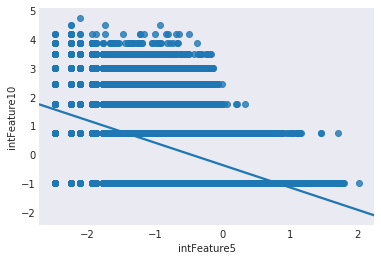

In [28]:
import seaborn as sns
# fig, ax_grid = plt.subplots(2, 1, figsize=(15,15)
sns.regplot(x='intFeature5', y="intFeature10",data=trainSampleLogNorm)                            
plt.show()

Looking at the above scatter plot between intFeature7 and intFeature11 it appears that those two variables have close to perfect collinearity. This behavior can confuse our learning model....elaborate on this. May make sense to drop either intFeature11 or intFeature7

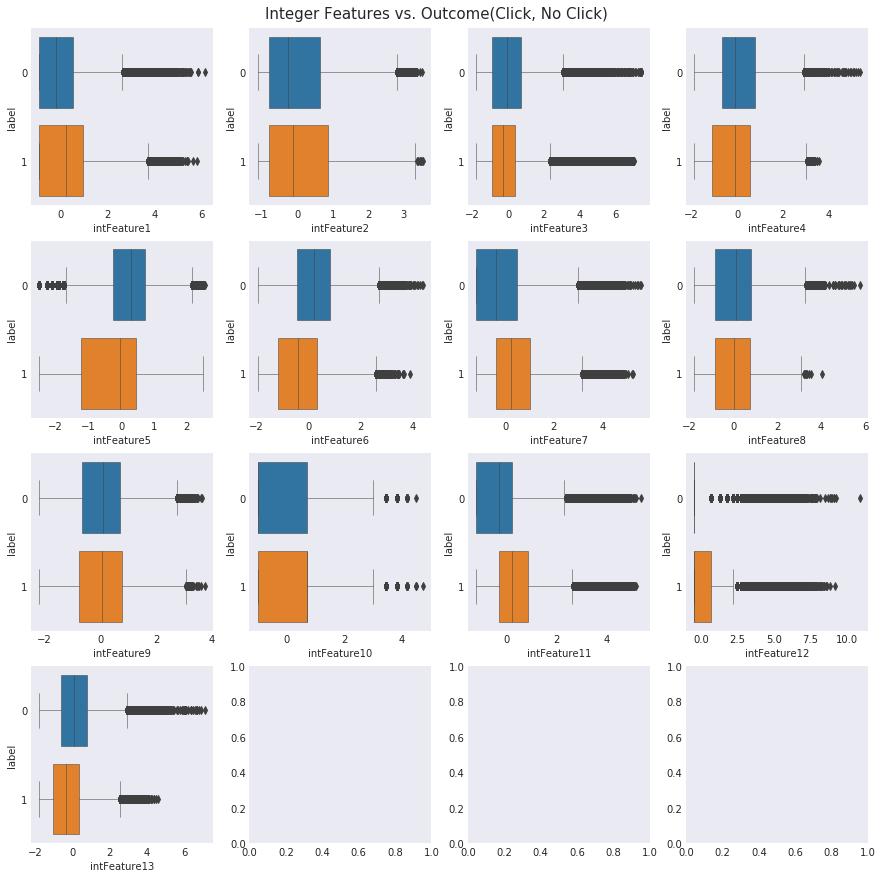

In [69]:
#multivariate analysis against target feature
"""plot boxplots of each feature vs. the outcome"""
fig, ax_grid = plt.subplots(4, 4, figsize=(15,15))
y = trainSampleLogNorm['label']
for idx, feature in enumerate(intFeatures):
    x = trainSampleLogNorm[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
#     ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Integer Features vs. Outcome(Click, No Click)", fontsize=15, y=0.9)
plt.show()

outliers skewing data, so it's difficult to gauge differences in boxplots. may make sense to bin our integer data
see here for reference on [adaptive binning](https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b)
transforming integer counts to interval data...maybe?

so far, most integer features don't seem to show much linear association with click success or failure

### EDA Categorical Data 

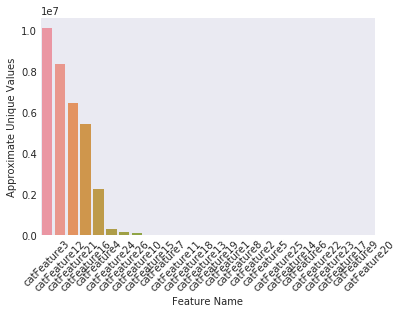

In [23]:
uniqueCounts = pd.read_csv('eda/featureCounts_unique.csv')
categoryLevels = uniqueCounts[uniqueCounts['Feature Name'].str.contains('cat')]
sns.barplot('Feature Name', 'Approximate Unique Values',data = categoryLevels)
plt.xticks(rotation=45)
plt.show()

There are an extremely high number of levels within most categorical features and unfortunately we're given no information about the semantics of the levels within each category it's difficult to reduce these lacking that context. For instance, catFeature3 may be page content that could be reduced to a broader classification of content such as sports, finance, etc

In [24]:
categoryLevels

,Feature Name,Approximate Unique Values
0,catFeature3,10109504
1,catFeature12,8365982
2,catFeature21,6449535
3,catFeature16,5436217
4,catFeature4,2239607
6,catFeature24,281672
7,catFeature26,148093
8,catFeature10,95718
9,catFeature15,15286
11,catFeature7,12507


In [61]:
#let's look at relative frequency of each level among our categories
def levelRarity(DataFrame,FeatureSet,threshold = 10):
    '''takes a dataset and given list of its categorical features and returns 
    the percentage of levels in a category with fewer observations than
    the threshold (rarity)'''
    #construct dictionary with features as keys
    fDict = {f:None for f in FeatureSet}

    for f in FeatureSet:
        x = DataFrame[f].value_counts()
        num = len(x[x<threshold])
        denom = len(x)
        #update feature value with percent less than threshold
        fDict[f] = num/denom

    return pd.DataFrame.from_dict(fDict, orient='index',columns = ["% of levels w/ obs < "+ str(threshold)])

FeatureSet = np.array(categoryLevels['Feature Name'])

levelRarity(trainSampleLogNorm,FeatureSet)

,% of levels w/ obs < 10
catFeature3,0.983703
catFeature12,0.981044
catFeature21,0.977976
catFeature16,0.972554
catFeature4,0.942490
catFeature24,0.853626
catFeature26,0.830430
catFeature10,0.716533
catFeature15,0.477884
catFeature7,0.230520


In [116]:
#iteratively build dataframe with categorical adjustments

for f in catFeatures:
    newCol_name = f + "_binned"
    row_elements = []
    #counts of unique labels per category
    uniq = trainSampleLogNorm[f].value_counts()
    #indx of labels with fewer than 30 observations (return the labels with .index)
    idx = set(uniq[uniq<30].index)
    labels = trainSampleLogNorm[f].values
    for label in labels:
        if label in idx:
            row_elements.append(f+"-bucket")
        else:
            row_elements.append(label)
            
    trainSampleLogNorm[newCol_name] = row_elements


In [120]:
#write to file for later use
fpath = 'eda/trainSampleLogNorm_Binned.csv'
trainSampleLogNorm.to_csv(path_or_buf = fpath, index = False)

In [7]:
#read in normalized train data
trainLogNormBinned = pd.read_csv('eda/trainSampleLogNorm_Binned.csv')
trainLogNormBinned.head(5)

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,catFeature17_binned,catFeature18_binned,catFeature19_binned,catFeature20_binned,catFeature21_binned,catFeature22_binned,catFeature23_binned,catFeature24_binned,catFeature25_binned,catFeature26_binned
0,0,NaN,NaN,1.099131,-0.101163,1.067417,NaN,-1.188550,-0.565069,-1.189582,...,1e88c74f,9880032b,21ddcdc9,5840adea,catFeature21-bucket,NaN,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,NaN,NaN,-1.221917,NaN,0.515437,-1.153559,0.226893,-1.764770,0.495264,...,e5ba7672,47e4d79e,21ddcdc9,a458ea53,catFeature21-bucket,NaN,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,-0.894306,NaN,-0.454853,-0.665177,0.238106,0.325690,1.181370,0.687097,0.893698,...,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,NaN,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,-0.894306,NaN,0.407084,0.953840,0.276778,0.396706,0.324023,0.869964,0.591389,...,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,ad3062eb,32c7478e,1793a828,e8b83407,2fede552
4,0,-0.894306,NaN,-0.641655,2.324844,0.090617,1.085939,-0.180168,1.510073,0.897876,...,07c540c4,e7e991cb,68c36492,a458ea53,catFeature21-bucket,NaN,3a171ecb,catFeature24-bucket,fd2fe0bd,catFeature26-bucket


In [19]:
#cleaning for train/test
#drop intFeature12 and catFeature22 based on columnwise incompleteness
trainLogNormBinned = trainLogNormBinned.drop(columns = ['intFeature12','catFeature22'])
#dropping rowise incompleteness (must be 3/4 complete)


In [31]:
#drop form cat variables (unbinned)
# unbinned_catFeatures = ['catFeature1', 'catFeature2', 'catFeature3', 'catFeature4',
#        'catFeature5', 'catFeature6', 'catFeature7', 'catFeature8',
#        'catFeature9', 'catFeature10', 'catFeature11', 'catFeature12',
#        'catFeature13', 'catFeature14', 'catFeature15', 'catFeature16',
#        'catFeature17', 'catFeature18', 'catFeature19', 'catFeature20',
#        'catFeature21', 'catFeature23', 'catFeature24', 'catFeature25',
#        'catFeature26']
# trainLogNormBinned = trainLogNormBinned.drop(columns = unbinned_catFeatures)


In [33]:
# trainLogNormBinned = trainLogNormBinned.drop(columns = ['catFeature22_binned'])
trainLogNormBinned.shape

(2291847, 38)

In [23]:
trainLogNormBinned = trainLogNormBinned.dropna(thresh = 30 )

In [36]:
trainLogNormBinned.shape

(2291847, 38)

In [51]:
#replacing missing categorical values with its own bucket (_NA)
catFeatures = trainLogNormBinned.columns[13:]
for f in catFeatures:
    new_bucket = f+"_NA"
    trainLogNormBinned[f].fillna(new_bucket,inplace = True)

In [54]:
trainLogNormBinned['intFeature2'].mean()

-3.668122845783655e-12

In [55]:
#replacing missing integer values with the mean
intFeatures = trainLogNormBinned.columns[1:13]
for f in intFeatures:
    colMean = trainLogNormBinned[f].mean()
    trainLogNormBinned[f].fillna(colMean,inplace = True)

In [80]:
#write pre-processed data to file for later use
trainLogNormBinned.to_csv('eda/pre-processed.csv', index = False)

In [ ]:
#read pre-processed data


In [65]:
#split processed data into train and test set
from sklearn.model_selection import train_test_split
y = trainLogNormBinned.label
X = trainLogNormBinned.drop(columns = ['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [73]:
#write to file train and test data for later use
X_train.to_csv('eda/X_train.csv', index = False)
X_test.to_csv('eda/X_test.csv', index = False)
y_train.to_csv('eda/y_train.csv', index = False)
y_test.to_csv('eda/y_test.csv', index = False)

In [75]:
intFeatures = trainLogNormBinned.columns[1:13]
catFeatures = trainLogNormBinned.columns[13:]
target = trainLogNormBinned.columns[0]

### Taking a Go at Logistic Regression as is on Pre-Processed Data

#### Notes on the preprocessed data
* dropped intFeature12 and catFeature22 based on columnwise incompleteness
* dropped rows missing 3/4 or more of total features values ~at least 30 columns needed to have data
* converted negative integer values in intFeature2 to absolute value (assumed negative was input error)
* log transformed and normalized integer features
* bucketed levels/labels that have fewer than 30 observations into a single level/label per category feature (ends with _binned)
* imputed NaN values:
    *created a new label/level for categorical NaN values
    *imputed mean of column for int features
    
Resources:
- [see logistic regression section](https://spark.apache.org/docs/latest/mllib-linear-methods.html)

In [30]:
intFeatures = ['intFeature1', 'intFeature2', 'intFeature3', 'intFeature4',
       'intFeature5', 'intFeature6', 'intFeature7', 'intFeature8',
       'intFeature9', 'intFeature10', 'intFeature11', 'intFeature13']
catFeatures = ['catFeature3_binned', 'catFeature1_binned', 'catFeature2_binned',
       'catFeature4_binned', 'catFeature5_binned', 'catFeature6_binned',
       'catFeature7_binned', 'catFeature8_binned', 'catFeature9_binned',
       'catFeature10_binned', 'catFeature11_binned', 'catFeature12_binned',
       'catFeature13_binned', 'catFeature14_binned', 'catFeature15_binned',
       'catFeature16_binned', 'catFeature17_binned', 'catFeature18_binned',
       'catFeature19_binned', 'catFeature20_binned', 'catFeature21_binned',
       'catFeature23_binned', 'catFeature24_binned', 'catFeature25_binned',
       'catFeature26_binned']

target = ['click']

In [7]:
#setting schema and reading in pre-processed data to pyspark dataframe
outcomeField = [StructField("click", IntegerType(), True)]
quantFields = [StructField(f, DoubleType(), True) for f in intFeatures]
qualFields = [StructField(f, StringType(), True) for f in catFeatures]
schema = StructType(outcomeField + quantFields + qualFields)

df = spark.read.schema(schema) \
    .option("ignoreLeadingWhiteSpace",True) \
    .option("ignoreTrailingWhiteSpace",True) \
    .csv('eda/pre-processed.csv',nullValue = "NaN")

In [8]:
catCols = [f for f in df.columns if "cat" in f]
numericCols = [f for f in df.columns if "int" in f]
target = ['click']
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="skip") for c in catCols]
label = StringIndexer(inputCol= target[0], outputCol="label", handleInvalid="skip")

In [9]:
#formatting for logistic regression
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers],
    dropLast=False)

assembler = VectorAssembler(
    inputCols= encoder.getOutputCols() + numericCols,
    outputCol= "features")

pipeline = Pipeline(stages = indexers + [encoder,assembler,label])

processedDF = pipeline.fit(df).transform(df)

In [10]:
# Keep relevant columns
selectedcols = ["label", "features"]
dataset = processedDF.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector]

In [11]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

1603982
687865


In [12]:
# Create initial LogisticRegression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [14]:
# Make predictions on test data using the transform() method. - LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

In [15]:
# View model's predictions and probabilities of each prediction class
# You can select any columns granted they're in the schema
selected = predictions.select("label", "prediction", "probability")
selected.show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.92870709566892...|
|  0.0|       0.0|[0.85836635788769...|
|  0.0|       0.0|[0.89089600238478...|
|  0.0|       0.0|[0.85420658571523...|
|  0.0|       0.0|[0.61823702911393...|
+-----+----------+--------------------+
only showing top 5 rows



#### Evaluation of Logistic Regression Model Fit

[scikit LogLoss](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)

[when accuracy doesn't make sense](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)

[good site for log loss](https://deeplearningretreat.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation/)

Accuracy vs LogLoss(cross-entropy loss)

* Accuracy is the number of predictions correct out of all predictions. Accuracy can be a flawed evaluation metric when there is a sizable discrepancy between the number of samples belonging to each class. In the context of our dataset, roughly 3/4 of the data belong to our "no-click" class (0) and 1/4 of the sample belongs to our "click" class (1). Given that ratio, our model can easily get 75% training accuracy by simply predicting every training sample belonging to the "no-click" class. Accuracy tends to work well only when there are a near equal number of samples belonging to each class. Further, accuracy gives no context with respect to costs. It may be much more costly to make false positives than false negatives. Accuracy doesn't give us a means to make that distinction.

* Log loss takes into account the uncertainty of predictions based on how much they vary from the actual label. Log loss penalizes both types of errors, but especially those predications that are confident (higher or lower probabilities) and wrong. Our logistic regression model outputs probabilities for each label (no click, click) so we can use those to compute the log loss of our model. A log loss close to zero implies that are probabilities are both very confident and accurate. So, the lower the log loss, the better the fit.

for a single sample/record, log loss is defined as the negative log-likelihood of the classifier given the true label:

$L_{\log}(y, p) = -\log \operatorname{Pr}(y|p) = -(y \log (p) + (1 - y) \log (1 - p))$

where $p = \operatorname{Pr}(y = 1)$ and $y \in \{0,1\}$ is the true label

and for the entire dataset:

$L_{\log}(Y, P) = -\log \operatorname{Pr}(Y|P) = - \frac{1}{N} \sum_{i=0}^{N-1} \sum_{k=0}^{K-1} y_{i,k} \log p_{i,k}$

In [17]:
#converting to pandas dataframe...has to be a better way to do this with just pyspark
mod_output = selected.toPandas()
mod_output.head(5)

,label,prediction,probability
0,0.0,0.0,"[0.9287070956689216, 0.07129290433107825]"
1,0.0,0.0,"[0.8583663578876993, 0.1416336421123006]"
2,0.0,0.0,"[0.8908960023847876, 0.10910399761521238]"
3,0.0,0.0,"[0.8542065857152341, 0.14579341428476583]"
4,0.0,0.0,"[0.6182370291139324, 0.38176297088606764]"


In [21]:
#pyspark doesn't have a logLoss evaluation method in its Evaluator class so we need to write our own function

import math

def logLoss(df):
    '''takes the pandas dataframe resulting from fitting our test set
    against our logistic regression model'''
    logLoss_vals = []
    epsilon = 1e-16
    for idx in df.index:
        if df.label[idx] == 1:
            #the 2nd element in the list (index 1) is the probability of click
            loss = -math.log(df.probability[idx][1] + epsilon)
        else:
            loss = -math.log(1. - df.probability[idx][1] + epsilon)
        
        logLoss_vals.append(loss)
        
    return np.mean(logLoss_vals)

logLoss(mod_output)

0.47331558641314886

initial model resulted in a LogLoss of .47

In [43]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
#need a user defined function to manipulate columns of array types
firstelement=udf(lambda v:float(v[1]),FloatType())
selected.select(firstelement('probability')).show(5)

+---------------------+
|<lambda>(probability)|
+---------------------+
|           0.07129291|
|           0.14163364|
|             0.109104|
|           0.14579341|
|           0.38176298|
+---------------------+
only showing top 5 rows



In [54]:
#pyspark implementation for logLoss
pyspark_mod = selected.withColumn(
        'logloss'
        , -f.col('label')*f.log(firstelement(f.col('probability'))) - (1.-f.col('label'))*f.log(1.-firstelement(f.col('probability')))
    )
pyspark_modLL = pyspark_mod.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']

In [55]:
pyspark_modLL

0.47331558636583215

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate model accuracy (default is area under ROC curve)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.7751897874589211

manual feature selection (see preprocessed notes) with binary logistic regression yielded accuracy of .775

#### Regularizing with Lasso
Lasso shrinks the less important feature’s coefficient to zero, and therefore, may remove some feature altogether. So, this can be another form of feature selection when we have a large number of features
[see reference](https://spark.apache.org/docs/1.5.2/ml-linear-methods.html)

In [37]:
#logistic regression with lasso regularization
lr_l1 = LogisticRegression(labelCol="label", featuresCol="features", regParam=0.0, elasticNetParam =1.0, maxIter=10)
# Fit the model
lrModel_lasso = lr_l1.fit(trainingData)

In [38]:
predictions_lasso = lrModel_lasso.transform(testData)

In [39]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions_lasso)

0.7751897874589285

### Testing Fit after Dropping intFeature11
removing near perfect collinearity in the dataset

In [31]:
#reading in the pre-processed data
#setting schema and reading in pre-processed data to pyspark dataframe
outcomeField = [StructField("click", IntegerType(), True)]
quantFields = [StructField(f, DoubleType(), True) for f in intFeatures]
qualFields = [StructField(f, StringType(), True) for f in catFeatures]
schema = StructType(outcomeField + quantFields + qualFields)

df = spark.read.schema(schema) \
    .option("ignoreLeadingWhiteSpace",True) \
    .option("ignoreTrailingWhiteSpace",True) \
    .csv('eda/pre-processed.csv',nullValue = "NaN")

In [32]:
#drop feature that is highly correlated with intFeature7
df = df.drop('intFeature11')

In [37]:
#prep for training
catCols = [f for f in df.columns if "cat" in f]
numericCols = [f for f in df.columns if "int" in f]
target = ['click']
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="skip") for c in catCols]
label = StringIndexer(inputCol= target[0], outputCol="label", handleInvalid="skip")

In [38]:
#formatting for logistic regression
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers],
    dropLast=False)

assembler = VectorAssembler(
    inputCols= encoder.getOutputCols() + numericCols,
    outputCol= "features")

pipeline = Pipeline(stages = indexers + [encoder,assembler,label])

processedDF = pipeline.fit(df).transform(df)

In [40]:
# Keep relevant columns and split for train/test
selectedcols = ["label", "features"]
dataset = processedDF.select(selectedcols)
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)

In [41]:
# Create initial LogisticRegression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [42]:
# Make predictions on test data using the transform() method. - LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)
# You can select any columns granted they're in the schema
selected = predictions.select("label", "prediction", "probability")

In [44]:
#evaluation of logit fit after dropping intFeature 11 with logLoss
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
#need a user defined function to manipulate columns of array types
firstelement=udf(lambda v:float(v[1]),FloatType())

#pyspark implementation for logLoss
pyspark_mod = selected.withColumn(
        'logloss'
        , -f.col('label')*f.log(firstelement(f.col('probability'))) - (1.-f.col('label'))*f.log(1.-firstelement(f.col('probability')))
    )


pyspark_mod.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']

0.4745497451524262

### Binning the Int Features data as a method of feature engineering

We saw that the integer features were still very skewed after log-transforming and normalizing them. Our model may benefit from improving the distribution of those

In [8]:
#load the trainSample into memory with a pandas dataframe
import glob
files = np.sort(glob.glob('eda/trainSample/*.csv'))
trainSample = pd.concat([pd.read_csv(f) for f in files],ignore_index = True)

In [9]:
#replace negative values with NaNs in intFeature2
f2 = trainSample['intFeature2']
neg_vals = f2[f2<0].unique()
trainSample.intFeature2 = trainSample['intFeature2'].replace(to_replace = neg_vals, value = np.NaN)

In [66]:
#drop columns missing most of their data; drop rows missing most of their data
# trainSample = trainSample.drop(columns = ['intFeature12','catFeature22']) \
#                 .dropna(thresh = 30 )

In [72]:
#impute mean on int Features
intFeatures = trainSample.columns[1:13]
for f in intFeatures:
    colMean = trainSample[f].mean()
    trainSample[f].fillna(colMean,inplace = True)
    
trainSample.head(5)

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,catFeature16,catFeature17,catFeature18,catFeature19,catFeature20,catFeature21,catFeature23,catFeature24,catFeature25,catFeature26
0,0,3.504356,115.555623,31.0,4.000000,33060.0,113.874226,0.0,3.0,4.0,...,e43a2c3f,1e88c74f,9880032b,21ddcdc9,5840adea,baf3777b,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,3.504356,115.555623,1.0,7.382695,6576.0,3.000000,6.0,0.0,76.0,...,75aaa8ad,e5ba7672,47e4d79e,21ddcdc9,a458ea53,f93c1581,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,0.000000,115.555623,4.0,2.000000,2921.0,52.000000,25.0,16.0,146.0,...,c2807520,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,0.000000,115.555623,13.0,12.000000,3271.0,59.000000,7.0,20.0,89.0,...,587267a3,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,32c7478e,1793a828,e8b83407,2fede552
4,0,0.000000,115.555623,3.0,44.000000,1897.0,199.000000,3.0,43.0,147.0,...,d46dd85d,07c540c4,e7e991cb,68c36492,a458ea53,c39d0f12,3a171ecb,abec2c22,fd2fe0bd,22538d57


In [73]:
#iteratively build dataframe with quantile binning on intFeatures

for f in intFeatures:
    newCol_name = f + "_Qbin"
    trainSample[newCol_name] = pd.qcut(trainSample[f].rank(method='first'), 4)

trainSample.head(5)

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,intFeature3_Qbin,intFeature4_Qbin,intFeature5_Qbin,intFeature6_Qbin,intFeature7_Qbin,intFeature8_Qbin,intFeature9_Qbin,intFeature10_Qbin,intFeature11_Qbin,intFeature13_Qbin
0,0,3.504356,115.555623,31.0,4.000000,33060.0,113.874226,0.0,3.0,4.0,...,"(1545001.0, 2060001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]","(0.999, 515001.0]","(0.999, 515001.0]","(515001.0, 1030001.0]","(0.999, 515001.0]","(515001.0, 1030001.0]"
1,1,3.504356,115.555623,1.0,7.382695,6576.0,3.000000,6.0,0.0,76.0,...,"(0.999, 515001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]"
2,1,0.000000,115.555623,4.0,2.000000,2921.0,52.000000,25.0,16.0,146.0,...,"(515001.0, 1030001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]","(1545001.0, 2060001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]"
3,0,0.000000,115.555623,13.0,12.000000,3271.0,59.000000,7.0,20.0,89.0,...,"(1030001.0, 1545001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(1545001.0, 2060001.0]"
4,0,0.000000,115.555623,3.0,44.000000,1897.0,199.000000,3.0,43.0,147.0,...,"(0.999, 515001.0]","(1545001.0, 2060001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1545001.0, 2060001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(1545001.0, 2060001.0]"


In [78]:
#iteratively build dataframe with categorical adjustments
catFeatures = trainSample.columns[13:38]
for f in catFeatures:
    newCol_name = f + "_binned"
    row_elements = []
    #counts of unique labels per category
    uniq = trainSample[f].value_counts()
    #indx of labels with fewer than 30 observations (return the labels with .index)
    idx = set(uniq[uniq<30].index)
    labels = trainSample[f].values
    for label in labels:
        if label in idx:
            row_elements.append(f+"-bucket")
        else:
            row_elements.append(label)
            
    trainSample[newCol_name] = row_elements
    
trainSample.head(5)

,label,intFeature1,intFeature2,intFeature3,intFeature4,intFeature5,intFeature6,intFeature7,intFeature8,intFeature9,...,catFeature16_binned,catFeature17_binned,catFeature18_binned,catFeature19_binned,catFeature20_binned,catFeature21_binned,catFeature23_binned,catFeature24_binned,catFeature25_binned,catFeature26_binned
0,0,3.504356,115.555623,31.0,4.000000,33060.0,113.874226,0.0,3.0,4.0,...,e43a2c3f,1e88c74f,9880032b,21ddcdc9,5840adea,catFeature21-bucket,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,3.504356,115.555623,1.0,7.382695,6576.0,3.000000,6.0,0.0,76.0,...,catFeature16-bucket,e5ba7672,47e4d79e,21ddcdc9,a458ea53,catFeature21-bucket,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,0.000000,115.555623,4.0,2.000000,2921.0,52.000000,25.0,16.0,146.0,...,c2807520,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,0.000000,115.555623,13.0,12.000000,3271.0,59.000000,7.0,20.0,89.0,...,587267a3,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,32c7478e,1793a828,e8b83407,2fede552
4,0,0.000000,115.555623,3.0,44.000000,1897.0,199.000000,3.0,43.0,147.0,...,catFeature16-bucket,07c540c4,e7e991cb,68c36492,a458ea53,catFeature21-bucket,3a171ecb,catFeature24-bucket,fd2fe0bd,catFeature26-bucket


In [85]:
all_catFeatures = trainSample.columns.str.contains('cat')
all_catFeatures = trainSample.columns[catFeatures]
all_catFeatures

Index(['catFeature1', 'catFeature2', 'catFeature3', 'catFeature4',
       'catFeature5', 'catFeature6', 'catFeature7', 'catFeature8',
       'catFeature9', 'catFeature10', 'catFeature11', 'catFeature12',
       'catFeature13', 'catFeature14', 'catFeature15', 'catFeature16',
       'catFeature17', 'catFeature18', 'catFeature19', 'catFeature20',
       'catFeature21', 'catFeature23', 'catFeature24', 'catFeature25',
       'catFeature26', 'catFeature1_binned', 'catFeature2_binned',
       'catFeature3_binned', 'catFeature4_binned', 'catFeature5_binned',
       'catFeature6_binned', 'catFeature7_binned', 'catFeature8_binned',
       'catFeature9_binned', 'catFeature10_binned', 'catFeature11_binned',
       'catFeature12_binned', 'catFeature13_binned', 'catFeature14_binned',
       'catFeature15_binned', 'catFeature16_binned', 'catFeature17_binned',
       'catFeature18_binned', 'catFeature19_binned', 'catFeature20_binned',
       'catFeature21_binned', 'catFeature23_binned', 'catFeature24_

In [86]:
#add NA buckets...can do this in the above code when building columns iteratively
for f in all_catFeatures:
    new_bucket = f+"_NA"
    trainSample[f].fillna(new_bucket,inplace = True)

In [101]:
#created dataframe of all binned features
binned = trainSample.columns.str.contains('bin|label')

trainSample_binned = trainSample.columns[binned]
trainSample_bins = trainSample[trainSample_binned]
trainSample_bins.head(5)

,label,intFeature1_Qbin,intFeature2_Qbin,intFeature3_Qbin,intFeature4_Qbin,intFeature5_Qbin,intFeature6_Qbin,intFeature7_Qbin,intFeature8_Qbin,intFeature9_Qbin,...,catFeature16_binned,catFeature17_binned,catFeature18_binned,catFeature19_binned,catFeature20_binned,catFeature21_binned,catFeature23_binned,catFeature24_binned,catFeature25_binned,catFeature26_binned
0,0,"(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1545001.0, 2060001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]","(0.999, 515001.0]","(0.999, 515001.0]",...,e43a2c3f,1e88c74f,9880032b,21ddcdc9,5840adea,catFeature21-bucket,32c7478e,5f13bb00,fd2fe0bd,aa5f0a15
1,1,"(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]",...,catFeature16-bucket,e5ba7672,47e4d79e,21ddcdc9,a458ea53,catFeature21-bucket,32c7478e,a9d771cd,c9f3bea7,0a47000d
2,1,"(0.999, 515001.0]","(1545001.0, 2060001.0]","(515001.0, 1030001.0]","(0.999, 515001.0]","(1030001.0, 1545001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]","(1545001.0, 2060001.0]",...,c2807520,e5ba7672,3cb7e3f0,21ddcdc9,b1252a9d,59a15e58,93bad2c0,8d653a3e,445bbe3b,8e1ae331
3,0,"(0.999, 515001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]","(1545001.0, 2060001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]","(1030001.0, 1545001.0]",...,587267a3,27c07bd6,a78bd508,21ddcdc9,5840adea,c2a93b37,32c7478e,1793a828,e8b83407,2fede552
4,0,"(0.999, 515001.0]","(1545001.0, 2060001.0]","(0.999, 515001.0]","(1545001.0, 2060001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(515001.0, 1030001.0]","(1545001.0, 2060001.0]","(1545001.0, 2060001.0]",...,catFeature16-bucket,07c540c4,e7e991cb,68c36492,a458ea53,catFeature21-bucket,3a171ecb,catFeature24-bucket,fd2fe0bd,catFeature26-bucket


In [15]:
#write to file for later use
fpath = 'eda/trainSampleBinned.csv'
trainSample_bins.to_csv(path_or_buf = fpath, index = False)

In [16]:
#setting up schema to read in pyspark dataframe
catFeatures_bin = ['intFeature1_Qbin', 'intFeature2_Qbin', 'intFeature3_Qbin',
       'intFeature4_Qbin', 'intFeature5_Qbin', 'intFeature6_Qbin',
       'intFeature7_Qbin', 'intFeature8_Qbin', 'intFeature9_Qbin',
       'intFeature10_Qbin', 'intFeature11_Qbin', 'intFeature13_Qbin',
       'catFeature1_binned', 'catFeature2_binned', 'catFeature3_binned',
       'catFeature4_binned', 'catFeature5_binned', 'catFeature6_binned',
       'catFeature7_binned', 'catFeature8_binned', 'catFeature9_binned',
       'catFeature10_binned', 'catFeature11_binned', 'catFeature12_binned',
       'catFeature13_binned', 'catFeature14_binned', 'catFeature15_binned',
       'catFeature16_binned', 'catFeature17_binned', 'catFeature18_binned',
       'catFeature19_binned', 'catFeature20_binned', 'catFeature21_binned',
       'catFeature23_binned', 'catFeature24_binned', 'catFeature25_binned',
       'catFeature26_binned']

target = ['click']

#setting schema and reading in pre-processed data to pyspark dataframe
outcomeField = [StructField("click", IntegerType(), True)]
qualFields = [StructField(f, StringType(), True) for f in catFeatures_bin]
schema = StructType(outcomeField + qualFields)

df = spark.read.schema(schema) \
    .option("ignoreLeadingWhiteSpace",True) \
    .option("ignoreTrailingWhiteSpace",True) \
    .csv('eda/trainSampleBinned.csv',nullValue = "NaN")

In [17]:
df.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|click|    intFeature1_Qbin|    intFeature2_Qbin|    intFeature3_Qbin|    intFeature4_Qbin|    intFeature5_Qbin|    intFeature6_Qbin|    intFeature7_Qbin|    intFeature8_Qbin|    intFeature9_Qbin|   intFeature10_Qbin|   intFeature11_Qbin|   intFea

In [10]:
df.columns[1:]

['intFeature1_Qbin',
 'intFeature2_Qbin',
 'intFeature3_Qbin',
 'intFeature4_Qbin',
 'intFeature5_Qbin',
 'intFeature6_Qbin',
 'intFeature7_Qbin',
 'intFeature8_Qbin',
 'intFeature9_Qbin',
 'intFeature10_Qbin',
 'intFeature11_Qbin',
 'intFeature13_Qbin',
 'catFeature1_binned',
 'catFeature2_binned',
 'catFeature3_binned',
 'catFeature4_binned',
 'catFeature5_binned',
 'catFeature6_binned',
 'catFeature7_binned',
 'catFeature8_binned',
 'catFeature9_binned',
 'catFeature10_binned',
 'catFeature11_binned',
 'catFeature12_binned',
 'catFeature13_binned',
 'catFeature14_binned',
 'catFeature15_binned',
 'catFeature16_binned',
 'catFeature17_binned',
 'catFeature18_binned',
 'catFeature19_binned',
 'catFeature20_binned',
 'catFeature21_binned',
 'catFeature23_binned',
 'catFeature24_binned',
 'catFeature25_binned',
 'catFeature26_binned']

In [18]:
catCols = df.columns[1:]
target = ['click']
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="skip") for c in catCols]
label = StringIndexer(inputCol= target[0], outputCol="label", handleInvalid="skip")

In [19]:
#formatting for logistic regression
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers],
    dropLast=False)

assembler = VectorAssembler(
    inputCols= encoder.getOutputCols(),
    outputCol= "features")

pipeline = Pipeline(stages = indexers + [encoder,assembler,label])

processedDF = pipeline.fit(df).transform(df)

In [22]:
processedDF.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------

In [23]:
# Keep relevant columns and split for train/test
selectedcols = ["label", "features"]
dataset = processedDF.select(selectedcols)
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)

In [24]:
# Create initial LogisticRegression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [25]:
# Make predictions on test data using the transform() method. - LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)
# You can select any columns granted they're in the schema
selected = predictions.select("label", "prediction", "probability")

In [26]:
#evaluation of logit fit after dropping intFeature 11 with logLoss
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
#need a user defined function to manipulate columns of array types
firstelement=udf(lambda v:float(v[1]),FloatType())

#pyspark implementation for logLoss
pyspark_mod = selected.withColumn(
        'logloss'
        , -f.col('label')*f.log(firstelement(f.col('probability'))) - (1.-f.col('label'))*f.log(1.-firstelement(f.col('probability')))
    )


pyspark_mod.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']

0.4781020603240861

In [27]:
##---------------__###

In [55]:
# from pyspark.ml.feature import Bucketizer

# splits = [-float("inf"), -0.5, 0.0, 0.5, float("inf")]

# data = [(-999.9,), (-0.5,), (-0.3,), (0.0,), (0.2,), (999.9,)]
# dataFrame = spark.createDataFrame(data, ["features"])

# bucketizer = Bucketizer(splits=splits, inputCol="features", outputCol="bucketedFeatures")

# # Transform original data into its bucket index.
# bucketedData = bucketizer.transform(dataFrame)

# print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits())-1))
# bucketedData.show()


Bucketizer output with 4 buckets
+--------+----------------+
|features|bucketedFeatures|
+--------+----------------+
|  -999.9|             0.0|
|    -0.5|             1.0|
|    -0.3|             1.0|
|     0.0|             2.0|
|     0.2|             2.0|
|   999.9|             3.0|
+--------+----------------+



In [ ]:
#---for pyspark---#
# from pyspark.ml.feature import Bucketizer
# bucketizer = Bucketizer(splits=[ 0, 6, 18, 60, float('Inf') ],inputCol="ages", outputCol="buckets")
# df_buck = bucketizer.setHandleInvalid("keep").transform(df)

# df_buck.show()

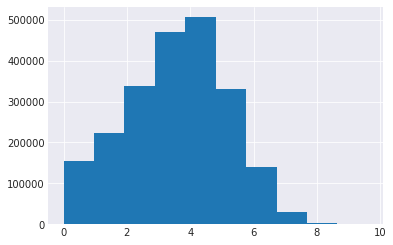

In [63]:
def log_transform(x):
    '''shifts x by un'''
    return np.log(x+1)
x = pd.value_counts(pd.cut(f9,15))

# ax = x.plot.bar(rot=0, color="b", figsize=(6,4))
# ax.set_xticklabels([c[1:-1].replace(","," to") for c in x.cat.categories])
# plt.show()
f9.apply(lambda x: np.log(x+1)).hist()

In [26]:
# load the raw training data into an RDD then split into a training and validation dataset
trainDataRDD = sc.textFile('data/train.txt')
trainRDD, validationRDD = trainDataRDD.randomSplit([0.8,0.2], seed = 1)

In [27]:
#will need to sample the data for EDA since we have such a large dataset (starting with 450K observations ~1% of all observations)
trainSample = trainRDD.map(lambda x: x.split('\t')) \
                .takeSample(False, 100000)

In [54]:
#transform ndarray to dataframe, add headers, and save to csv for later use
cols = ['outcome']+["var"+str(i+1) for i in np.arange(39)]
df = pd.DataFrame(trainSample,columns = cols)
df.to_csv(PWD + '/data/trainSample.csv', index = False)

In [60]:
#read in the csv data - this automatically converts datatypes to floats and ints
df = pd.read_csv('data/trainSample.csv')

In [56]:
#summary of our quantitative variables
#summary = df.describe()


>_ An initial look at the spread of each our our quantitative variables from our sample suggests we'll need to normalize these variables. We can also see that several quantitative variables have relatively few observations so sparsity will be a concern.

>_ we can see from our categorical variables that there are many levels within each category. For instance var16, var25, var34 all have over 40,000 levels. If we were to make indicator variables out of these, in the context of a logistic/binary regression, then we'll have a very high dimensional dataset.

### Initial Thoughts on Concepts

* a lot of work during the preprocess phase
* normalization
* sparsity
* regularization for feature selection in high dimensionality 
* binary logistic regression, its assumptions and the bias variance tradeoff
* scalability

In [21]:
#helper functions
#-columns are tab-separated

#note: to convert RDD to DataFrame in Pyspark, each record (line) needs to be converted to a row object
#a quick way to do this is to convert the record to a tuple

def Row_formatter(line):
    record = line.split('\t')
    return tuple(record)


In [40]:
df = trainDataRDD.map(Row_formatter).toDF()
df.show(1)

+---+---+---+---+---+----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+
| _1| _2| _3| _4| _5|  _6| _7| _8| _9|_10|_11|_12|_13|_14|     _15|     _16|     _17|     _18|     _19|     _20|     _21|     _22|     _23|     _24|     _25|     _26|     _27|     _28|     _29|     _30|     _31|     _32|     _33|     _34|     _35|_36|     _37|     _38|     _39|     _40|
+---+---+---+---+---+----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+
|  0|  1|  1|  5|  0|1382|  4| 15|  2|181|  1|  2|   |  2|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c98|7e0ccccf|de7995b8|1f89b562|a73ee5

In [ ]:
col_names = df.columns

df.select('_15').show(5)

In [39]:
df.count()

45840617

In [32]:
#number of records in the train data
trainDataRDD.map(formatter).count()

45840617

In [ ]:
records = trainDataRDD.map(formatter)

trainDF = spark.createDataFrame(trainData)

total of 45,840,617  observations in the train data

### PySpark Code to processing and model data

In [7]:
# 13 features taking integer values and 26 taking categorical values (we can't assume ordinal) - making total of 39 features + 1 outcome
outcomeField = [StructField("label", IntegerType(), True)]
quantFields = [StructField("intFeature"+str(i+1), IntegerType(), True) for i in np.arange(13)]
qualFields = [StructField("catFeature"+str(i+1), StringType(), True) for i in np.arange(26)]
schema = StructType(outcomeField + quantFields + qualFields)

df = spark.read \
    .schema(schema) \
    .format("csv") \
    .option("header", "true") \
    .load("eda/trainSample/*.csv")

In [8]:
#clean up: drop duplicate rows; rows missing at least 30 out of 39 values (>= 3/4 of row-wise data); columns missing >= 3/4 of data 
drop_cols = ['intFeature12','catFeature22']
df = df.dropDuplicates() \
    .dropna(thresh=30) \
    .drop(*drop_cols)

In [9]:
#-----------imputing missing values---------------#
#bucket missing values in categorical data into its own sub-category for all releveant columns
categoryCols = [col for col in  df.columns if 'cat' in col]
df = df.fillna("NA_Bucket", subset=categoryCols)

In [10]:
#assuming negative values in intFeatures were incorrectly coded and should be null
neg_overide = f.udf(lambda val: None if val < 0 else val, IntegerType())
df = df.withColumn('intFeature2', neg_overide(df.intFeature2))

##### --- Imputing Missing Values with Pyspark -----

In [11]:
#update categorical column values conditioned on the number of observations for each value

for c in categoryCols:
    
    #collect unique values with greater than 30 observations
    bucket = set(df.groupBy(c) \
    .count() \
    .filter(f.col('count') > 30) \
    .select(f.col(c)) \
    .rdd \
    .flatMap(lambda x: x) \
    .collect())
    
    #update dataframe with rare values (fewer than 30) as their own bucketed value
    df = df.withColumn(c, 
                   f.when(f.col(c).isin(bucket)
                        , f.col(c)).otherwise("Rare_Bucket"))

In [12]:
#update integer columns missing values with the column mean

integerCols = [col for col in  df.columns if 'int' in col]
mean_dict = {}
for c in integerCols:
    #compute mean for each column
    col_mean = df.select(f.mean(f.col(c)).alias('mean')).collect()[0]['mean']
    mean_dict[c] = col_mean

#update null values in int columns:
df = df.na.fill(mean_dict)

In [13]:
#log transform int variables
for c in integerCols:
    df = df.withColumn(c, 
                   f.log(f.col(c)+1))

In [15]:
# normalize
for c in integerCols:
    #compute mean for each column
    col_mean = df.select(f.mean(f.col(c)).alias('mean')).collect()[0]['mean']
    col_std = df.select(f.stddev(f.col(c)).alias('std')).collect()[0]['std']
    #update dataframe
    df = df.withColumn(c,(f.col(c) - col_mean)/col_std)

In [42]:
# write df to file for later use
df.write \
    .option("header", "true") \
    .csv("data/processed")

In [7]:
#setting schema and reading in pre-processed data to pyspark dataframe

integerCols = ['intFeature1', 'intFeature2', 'intFeature3', 'intFeature4',
       'intFeature5', 'intFeature6', 'intFeature7', 'intFeature8',
       'intFeature9', 'intFeature10', 'intFeature11', 'intFeature13']
       
categoryCols = ['catFeature1', 'catFeature2','catFeature3',
       'catFeature4', 'catFeature5', 'catFeature6',
       'catFeature7', 'catFeature8', 'catFeature9',
       'catFeature10', 'catFeature11', 'catFeature12',
       'catFeature13', 'catFeature14', 'catFeature15',
       'catFeature16', 'catFeature17', 'catFeature18',
       'catFeature19', 'catFeature20', 'catFeature21',
       'catFeature23', 'catFeature24', 'catFeature25',
       'catFeature26']

outcomeField = [StructField("click", IntegerType(), True)]
quantFields = [StructField(f, DoubleType(), True) for f in integerCols]
qualFields = [StructField(f, StringType(), True) for f in categoryCols]
schema = StructType(outcomeField + quantFields + qualFields)


df = spark.read \
    .schema(schema) \
    .format("csv") \
    .option("header", "true") \
    .load("data/processed/*.csv")

In [8]:
target = ['click']
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="skip") for c in categoryCols]
label = StringIndexer(inputCol= target[0], outputCol="label", handleInvalid="skip")

In [9]:
#formatting for logistic regression
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers],
    dropLast=False)

assembler = VectorAssembler(
    inputCols= encoder.getOutputCols() + integerCols,
    outputCol= "features")

pipeline = Pipeline(stages = indexers + [encoder,assembler,label])

processedDF = pipeline.fit(df).transform(df)

In [55]:
# Keep relevant columns and split for train/test
selectedcols = ["label", "features"]
dataset = processedDF.select(selectedcols)
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)

In [56]:
# Create initial LogisticRegression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [57]:
# Make predictions on test data using the transform() method. - LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)
# You can select any columns granted they're in the schema
selected = predictions.select("label", "prediction", "probability")

In [58]:
#evaluation of logit fit after dropping intFeature 11 with logLoss
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
#need a user defined function to manipulate columns of array types
firstelement=udf(lambda v:float(v[1]),FloatType())

#pyspark implementation for logLoss
pyspark_mod = selected.withColumn(
        'logloss'
        , -f.col('label')*f.log(firstelement(f.col('probability'))) - (1.-f.col('label'))*f.log(1.-firstelement(f.col('probability')))
    )


pyspark_mod.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']

0.4756830294388297

### -----End of Pyspark Code for PreProcessing and Model fitting

Run these cells to create the example corpus and model.